# Выявление опрееляющих успешность игры закономерности

## Обзор данных

In [1]:
import pandas as pd 
import numpy as np
import scipy.stats as st
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В таблице 11 столбцов с двумя типами данных: object и float. 
Object столбцы:
- name (название игры)  
- platform (платформа) Нужно проверить на наличие неявных дубликатов. 
- genre (жанр игры) Так же лучше проверить на наличие неявных дубликатов. 
- user_score (оценка пользователей, максимум 10) Нужно изменить тип данных на float, так как оценка - число. 
- rating (рейтинг от организации ESRB) Оценка категорийная, используются буквы алфавита, также можно проверить на наличие неявнях дубликатов. 

Float столбцы:
- year_of_release (год выпуска) Нужно изменить тип данных на int. 
- na_sales (продажи в Северной Америке (миллионы проданных копий))       
- eu_sales (продажи в Европе (миллионы проданных копий))        
- jp_sales (продажи в Японии (миллионы проданных копий))       
- other_sales (продажи в других странах (миллионы проданных копий))    
- critic_score (оценка критиков (максимум 100)) Нужно изменить тип данных на int.     
Что касается продаж, то в столбцах указаны сокращенные цифры, поэтому тип float. 
Также необходимо привести названия столбцов к ниженму регистру. 

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

In [5]:
# подсчёт пропусков
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
# проверка на дубликаты 
df.duplicated().sum()

0

Пропуски в названии игры скорее всего случайны. Лучше удалить эти две строки, они не повлияют на расчеты в дальнейшем. 
Пропуски в годах выпуска наверняка случайно образовались. 
Пропуски в рейтинге, оценке пользователей и оценке критиков возможны, если игры не оценивали, или еще нет данных. Пропуски в рейтинге можно заменить на "unknown". Пропуски в оценках критиков пока лучше оставить как есть. Стоит отметить, что в столбце с оценкой пользователей встречается аббревиатура 'tbd'. Даннаяя аббревиатура встречается в геймерском языке и расшифровывается как - To Be Determined или to be done, то есть "Будет определено". 'tbd' - можно заменить на NaN и привести у нужному типу.  

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Но встречаются пропуски в данных, а в названиях колонок — расхождения с хорошим стилем.
Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

### Стиль заголовков

In [7]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Устранение пропусков 

In [10]:
# заполнение пропусков в столбце rating
df['rating'] = df['rating'].fillna('unknown')

In [11]:
# удаление 2-х строк по столбцу name
df = df.dropna(subset=['name'])

In [12]:
# проверка после устранения пропусков
df.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating                0
dtype: int64

### Изменение типа данных 

In [13]:
# изменение типа данных в столбце user_score
df['user_score'] = pd.to_numeric(df['user_score'],errors='coerce')

In [14]:
# изменение типа данных с толбце year_of_release
df['year_of_release'] = df['year_of_release'].astype('Int64')

In [15]:
# проверка после изменения типа данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


## Исследовательский анализ

In [16]:
# создание столбца с общими продажами
df['total_sales'] = df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']

In [17]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown,0.01


### Cколько игр выпускалось в разные годы. Важны ли данные за все периоды?

Text(0, 0.5, 'Количество выпущенных игр')

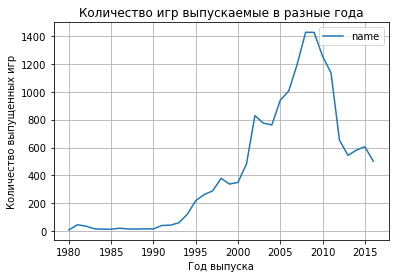

In [18]:
# создание таблицы и графика с выпущенными играми по годам
pivot_years = df.pivot_table(index='year_of_release',values='name',aggfunc='count').plot(grid=True)
plt.title('Количество игр выпускаемые в разные года')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпущенных игр')

Из графика видно, что с 1990 года начался рост выпуска консольных игр и рост продолжался вплоть до 2007 года. И уже с где-то с 2008 года наблюдается спад. Стоит отметить, что в 1997 году начали внедрять игры на мобильные телефоны. И уже в 2008 году игры на мобильных начали набирать популярность, на смену кнопочным телефонам, пришли смартфоны, которые становились значительно мощнее, открыв новые возможности в создании игр для разработчиков. Первой популярной игрой стала Angry Birds. Через год релиза её скачали более миллиона раз. Это пришлось как раз на 2008-2009 года. 
Важными данными можно считать данные за период с 1995 по 2016 года. 

### Проверим как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Text(0, 0.5, 'Сумма продаж')

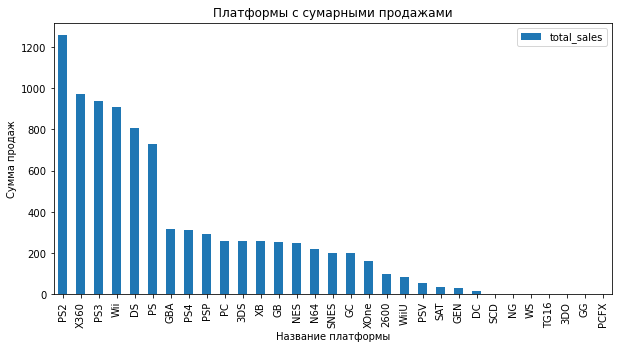

In [19]:
# создание таблицы и построение графика по платформам
pivot_platform = df.pivot_table(index='platform',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=False).plot(kind='bar',figsize=(10,5))
plt.title('Платформы с сумарными продажами')
plt.xlabel('Название платформы')
plt.ylabel('Сумма продаж')

Платформы с наибольшими суммарными продажами в порядке убывания: PS2, X360, PS3, Wii, DS, PS.

In [20]:
# создание таблицы с платформами, по которым самые большие суммарные продажи 
qw = df.query('platform == ["PS2","X360","PS3","Wii","DS","PS"]')
qw.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,9262.000000,9422.000000,9422.000000,9422.000000,9422.000000,4536.000000,4322.000000,9422.000000
mean,2006.758799,0.296712,0.170351,0.065436,0.063057,67.580908,7.055877,0.595556
std,4.514636,0.839197,0.589065,0.270931,0.233196,14.414530,1.517029,1.706487
min,1985.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000
25%,2005.000000,0.020000,0.000000,0.000000,0.000000,58.000000,6.300000,0.080000
50%,2008.000000,0.100000,0.030000,0.000000,0.020000,69.000000,7.400000,0.200000
75%,2010.000000,0.280000,0.140000,0.030000,0.050000,78.000000,8.200000,0.540000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,98.000000,9.500000,82.540000


Text(0, 0.5, 'Сумма продаж')

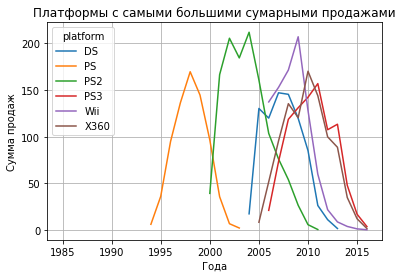

In [21]:
qw.pivot_table(index='year_of_release', columns='platform', values='total_sales',aggfunc='sum').plot(grid=True)
plt.title('Платформы с самыми большими сумарными продажами')
plt.xlabel('Года')
plt.ylabel('Сумма продаж')

 Согласно графику средняя продолжительность существования платформы около 10 лет. Первые 5 лет наблюдается рост, последующие 5 лет графики показывают падение -  и так абсолютно для каждой платформы. 
 Соотвественно, для того, чтобы построить прогоноз на следующий год, нужно взять информацию за предыдущие 3 года, т.е. с 2013 года. 
 Бросается в глазаа платформа Wii - на графике видет резкий рост, и такой же резкий спад. 

In [22]:
# Заполню года -1, чтобы сделать срез таблицы с 2010 года 
df['year_of_release'] = df['year_of_release'].fillna(-1).astype(int)

In [23]:
data = df.query('year_of_release >= 2013')

In [24]:
df['year_of_release'] = df['year_of_release'].astype(str).replace('-1', np.nan)

### Проверим какие платформы лидируют по продажам, растут или падают? Выберим несколько потенциально прибыльных платформ.

Text(0, 0.5, 'Сумма продаж')

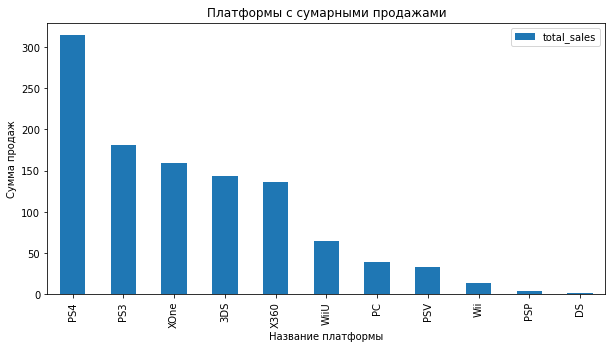

In [25]:
# Вычисление наиболее потенциально прибыльных платформ
pivot_data = data.pivot_table(index='platform',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=False).plot(kind='bar',figsize=(10,5))
plt.title('Платформы с сумарными продажами')
plt.xlabel('Название платформы')
plt.ylabel('Сумма продаж')

Text(0, 0.5, 'Сумма продаж')

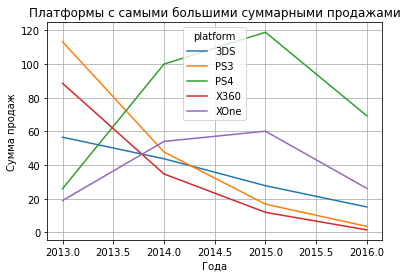

In [26]:
data.query('platform == ["X360","PS3","PS4","3DS","XOne"]').pivot_table(index='year_of_release', columns='platform', values='total_sales',aggfunc='sum').plot(grid=True)
plt.title('Платформы с самыми большими суммарными продажами')
plt.xlabel('Года')
plt.ylabel('Сумма продаж')

Платформы с самыми большими суммарными продажами за последние 5 лет это: PS4, PS3, XOne, 3DS, X360. На всех платформах продажи падают. Выделяется PS4 - на данной платформе продажи лидируют по сравнению с другими. 

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам  и опишем результат.

In [27]:
# создание таблицы с самыми большими суммарными продажами за последние 5 лет
df_top_platforms = data[data['platform'].isin(['PS4', 'PS3', 'XOne', '3DS', 'X360'])]
df_top_platforms['total_sales'].describe()

count    1473.000000
mean        0.634718
std         1.454708
min         0.010000
25%         0.050000
50%         0.170000
75%         0.580000
max        21.050000
Name: total_sales, dtype: float64

Text(0, 0.5, 'Глобальные продажи')

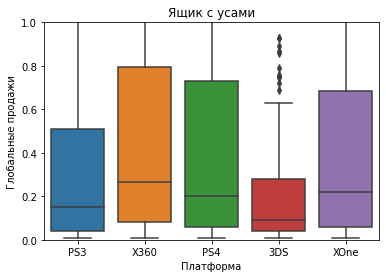

In [28]:
# построение ящика с усами
plt.ylim(0, 1)
sns.boxplot(data=df_top_platforms, x='platform', y='total_sales')
plt.title('Ящик с усами')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи')

Медиана у всех разная. Больше всего продаж на платформах X360 и PS4, похуже обстоят дела у XOne, PS3 и 3DS. 
Стоит отметить, что стандартное отклонение равно 1,59 - говорит о том, что в данных большой разброс по глобальным продажам. 

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [29]:
# возьмем для примера платформу X360
pl_x360 = df_top_platforms.query('platform == "X360"')

('Корреляция между оценками пользователей и продажами', -0.011742185147181351)

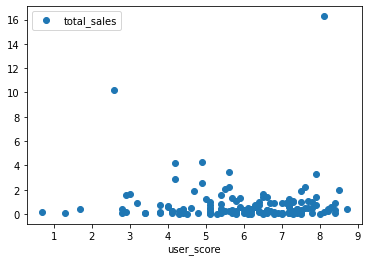

In [30]:
pl_x360.plot(x='user_score', y='total_sales', style = 'o')
('Корреляция между оценками пользователей и продажами', pl_x360['user_score'].corr(pl_x360['total_sales']))

Корреляция в -0.012 говорит о том, что зависимости нет.  

('Корреляция между оценками критиков и продажами', 0.3503445460228664)

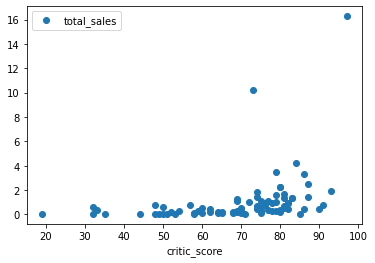

In [31]:
pl_x360.plot(x='critic_score', y='total_sales', style = 'o')
('Корреляция между оценками критиков и продажами', pl_x360['critic_score'].corr(pl_x360['total_sales']))

Корреляция в 0.35 говорит о том, что связь есть, но минимальная. 

### Соотнесем выводы с продажами игр на других платформах

In [32]:
df_top_platforms

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16672,Metal Gear Solid V: The Definitive Experience,XOne,2016,Action,0.01,0.00,0.00,0.00,NaN,NaN,M,0.01
16674,Tsukigime Ranko's Longest Day,PS3,2014,Action,0.00,0.01,0.00,0.00,NaN,NaN,unknown,0.01
16677,Aikatsu Stars! My Special Appeal,3DS,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16691,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01


In [33]:
list_of_platforms = ['3DS','PS3','PS4','X360','XOne']
def other_platform(name_of_platform):
    platform = df_top_platforms[df_top_platforms['platform']==name_of_platform]
    fig, ax = plt.subplots(1 ,2, figsize=(15,5))
    platform.plot(x='user_score', y='total_sales', style = 'o', ax=ax[0])
    platform.plot(x='critic_score', y='total_sales', style = 'o', ax=ax[1])
    fig.suptitle(name_of_platform, fontsize=15)
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Количество продаж')
    ax[1].set(ylabel='Количество продаж')
    user_correl = platform['user_score'].corr(platform['total_sales'])
    critic_correl = platform['critic_score'].corr(platform['total_sales'])
    if 0 >= user_correl >= -1:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform, ': Отрицательная', user_correl)
    if 0.3 >= user_correl >= 0:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform, ': Очень слабая', user_correl)
    if 0.5 >= user_correl >= 0.3:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform, ': Слабая', user_correl)
    if 0.7 >= user_correl >= 0.5:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform, ': Средняя', user_correl)
    if 0.9 >= user_correl >= 0.7:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform, ': Высокая', user_correl)
    if 1 >= user_correl >= 0.9:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform, ': Очень высокая', user_correl)
    if 0 >= critic_correl >= -1:
        print('Корреляция между отзывами критиков и продажами ', name_of_platform, ': Отрицательная', critic_correl)
    if 0.3 >= critic_correl >= 0:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform, ': Очень слабая', critic_correl)
    if 0.5 >= critic_correl >= 0.3:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform, ': Слабая', critic_correl)
    if 0.7 >= critic_correl >= 0.5:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform, ': Средняя', critic_correl)
    if 0.9 >= critic_correl >= 0.7:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform, ': Высокая', critic_correl)
    if 1 >= critic_correl >= 0.9:
        print('Корреляция между отзывами пользователей и продажами ', name_of_platform, ': Очень высокая', critic_correl)
    

Корреляция между отзывами пользователей и продажами  3DS : Очень слабая 0.2415041177356301
Корреляция между отзывами пользователей и продажами  3DS : Слабая 0.35705661422881046
Корреляция между отзывами пользователей и продажами  PS3 : Очень слабая 0.0023944027357566838
Корреляция между отзывами пользователей и продажами  PS3 : Слабая 0.3342853393371919
Корреляция между отзывами пользователей и продажами  PS4 : Отрицательная -0.03195711020455646
Корреляция между отзывами пользователей и продажами  PS4 : Слабая 0.40656790206178145
Корреляция между отзывами пользователей и продажами  X360 : Отрицательная -0.011742185147181351
Корреляция между отзывами пользователей и продажами  X360 : Слабая 0.3503445460228664
Корреляция между отзывами пользователей и продажами  XOne : Отрицательная -0.0689250532827942
Корреляция между отзывами пользователей и продажами  XOne : Слабая 0.4169983280084016


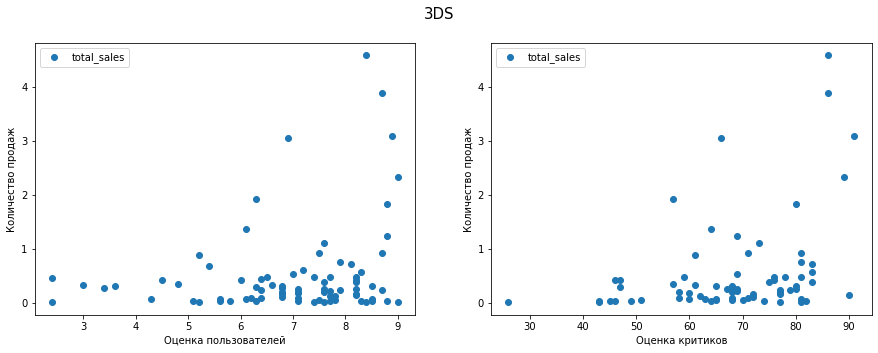

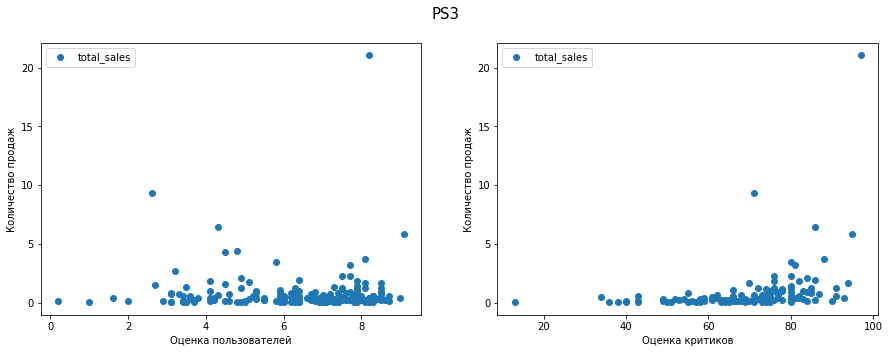

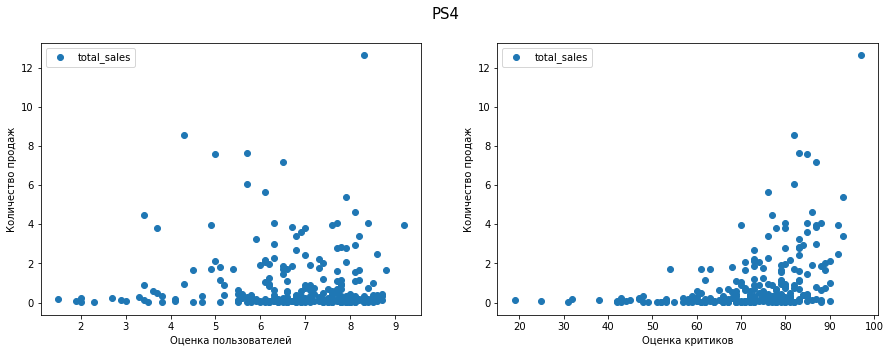

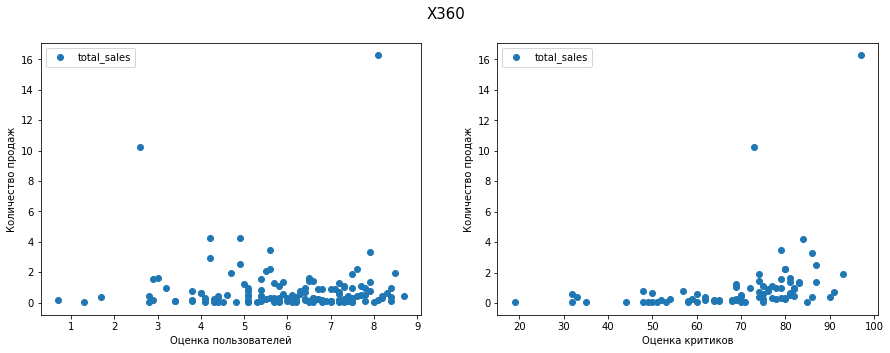

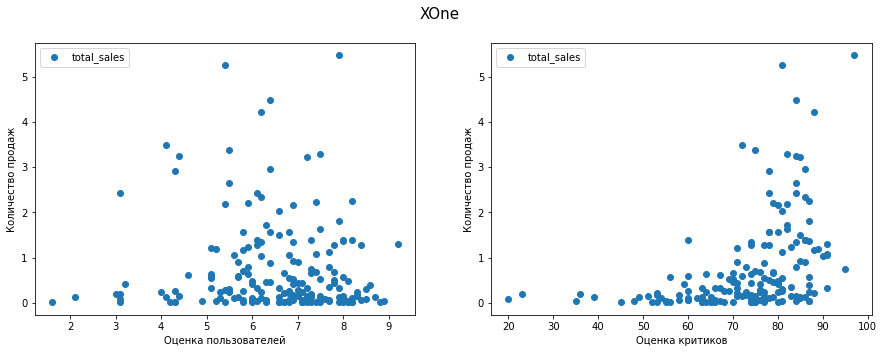

In [34]:
for platform in list_of_platforms:
    other_platform(platform)

Практически у всех платформ присутсвует корреляция между оценками пользователей и продажами и между оценками критиков и продажами. Но везде корреляция слабая. Пользователи не ориентируются ни на оценки пользователей, не на оценки критиков.

### Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [35]:
# создание таблицы с жанрами и продажами
genre_sales = data.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values(by='total_sales', ascending=False)
genre_sales.reset_index(inplace=True)
genre_sales

,genre,total_sales
0,Shooter,0.450
1,Sports,0.240
2,Platform,0.225
3,Role-Playing,0.125
4,Fighting,0.125
5,Racing,0.120
6,Action,0.110
7,Simulation,0.100
8,Misc,0.100
9,Strategy,0.080


Text(0, 0.5, 'Сумма продаж')

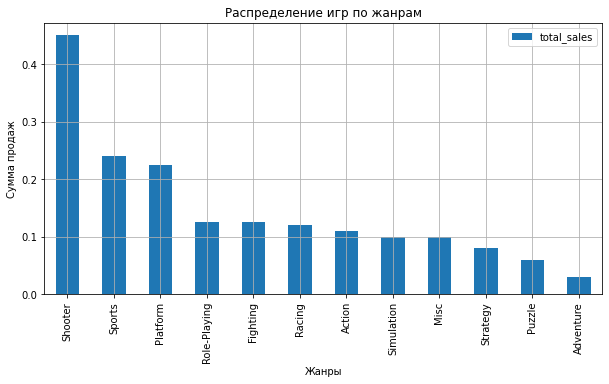

In [36]:
# создание столбчатой диаграммы для наглядности
genre_sales.plot(x='genre', y='total_sales', kind='bar',grid=True, figsize=(10,5))
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Сумма продаж')

Самым прибыльным жанром оказался Шутер, 2-ое место занимает Спорт, а 3-ье Платформер. С самой низкой прибылью Приключения и Пазл.

## Составим портрет пользователя каждого региона

('Доля продаж в Северной Америке:', 0.40131476404844635)

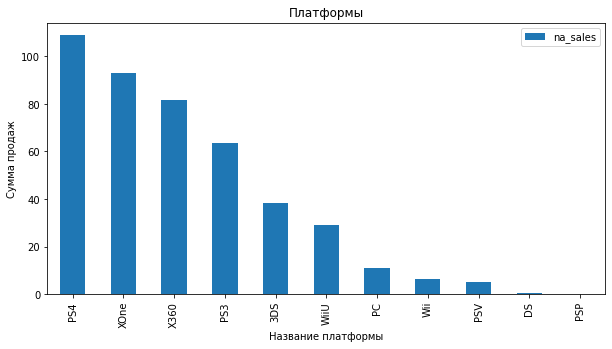

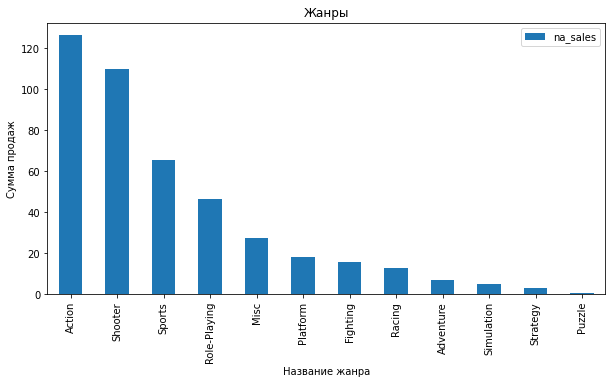

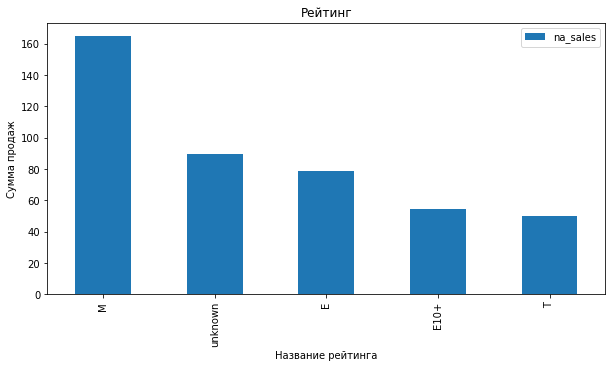

In [37]:
# Портрет пользователя в Северной Америке
na_sales_pivot = data.pivot_table(index='platform',values='na_sales',aggfunc='sum').sort_values(by='na_sales',ascending=False).plot(kind='bar',figsize=(10,5))
plt.title('Платформы')
plt.xlabel('Название платформы')
plt.ylabel('Сумма продаж')
na_genre_pivot = data.pivot_table(index='genre',values='na_sales',aggfunc='sum').sort_values(by='na_sales',ascending=False).plot(kind='bar',figsize=(10,5))
plt.title('Жанры')
plt.xlabel('Название жанра')
plt.ylabel('Сумма продаж')
na_rating_pivot = data.pivot_table(index='rating',values='na_sales',aggfunc='sum').sort_values(by='na_sales',ascending=False).plot(kind='bar',figsize=(10,5))
plt.title('Рейтинг')
plt.xlabel('Название рейтинга')
plt.ylabel('Сумма продаж')
('Доля продаж в Северной Америке:', (data['na_sales'].sum())/(data['total_sales'].sum()))

Пользователи из Северной Америки предпочитают платформы: PS4, XOne, X360, PS3, 3DS. Самые популярные жанры: экшн, шутер, спорт, ролевая, аркада. Также пользователи основываются на рейтинг ESRB. 

('Доля продаж в Европе:', 0.3596163896249163)

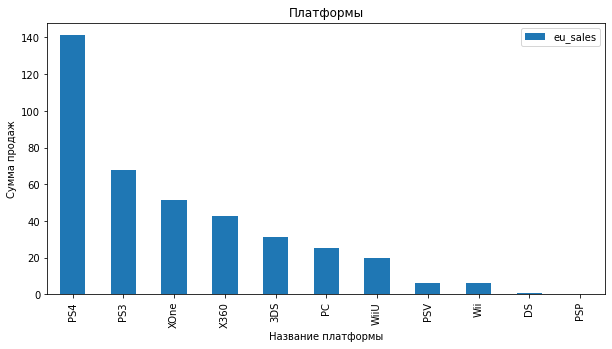

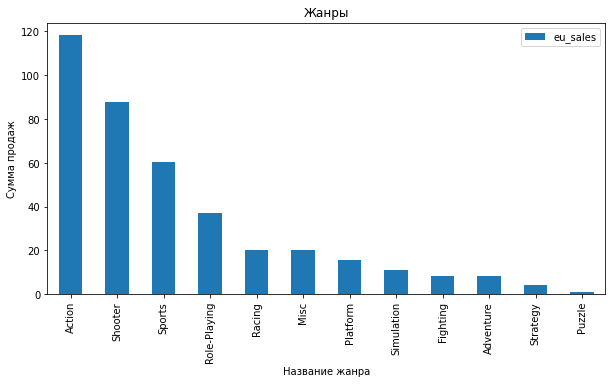

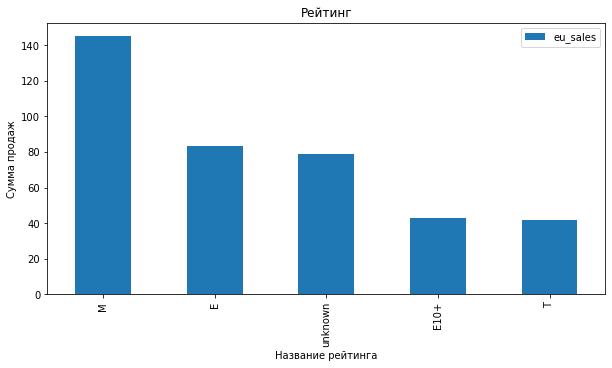

In [38]:
# портрет пользователя в Европе
eu_sales_pivot = data.pivot_table(index='platform',values='eu_sales',aggfunc='sum').sort_values(by='eu_sales',ascending=False).plot(kind='bar',figsize=(10,5))
plt.title('Платформы')
plt.xlabel('Название платформы')
plt.ylabel('Сумма продаж')
eu_genre_pivot = data.pivot_table(index='genre',values='eu_sales',aggfunc='sum').sort_values(by='eu_sales',ascending=False).plot(kind='bar',figsize=(10,5))
plt.title('Жанры')
plt.xlabel('Название жанра')
plt.ylabel('Сумма продаж')
eu_rating_pivot = data.pivot_table(index='rating',values='eu_sales',aggfunc='sum').sort_values(by='eu_sales',ascending=False).plot(kind='bar',figsize=(10,5))
plt.title('Рейтинг')
plt.xlabel('Название рейтинга')
plt.ylabel('Сумма продаж')
('Доля продаж в Европе:', (data['eu_sales'].sum())/(data['total_sales'].sum()))

Пользователи в Европе предпочитают PS4, PS3, XOne, X360, 3DS. По жанрам это экшн, шутер, спорт, ролевая и гонки. Пользователи также ориентируются на рейтинг ESRB.

('Доля продаж в Японии:', 0.12907425574636242)

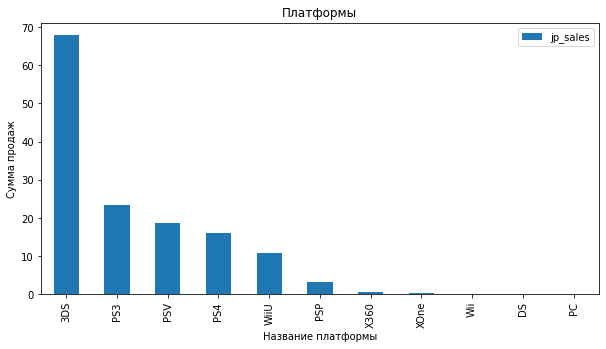

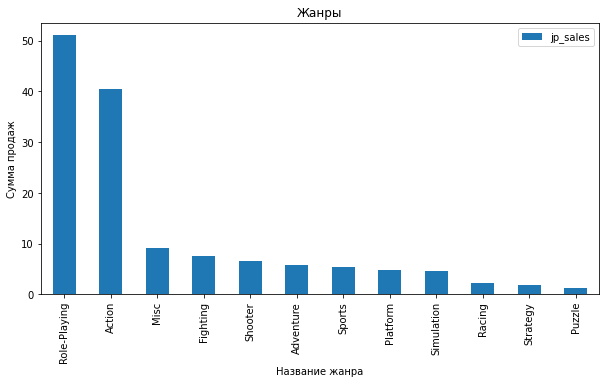

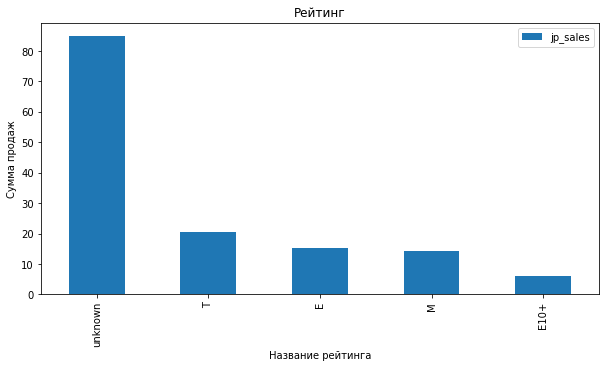

In [39]:
# портрет пользователя в Японии
jp_sales_pivot = data.pivot_table(index='platform',values='jp_sales',aggfunc='sum').sort_values(by='jp_sales',ascending=False).plot(kind='bar',figsize=(10,5))
plt.title('Платформы')
plt.xlabel('Название платформы')
plt.ylabel('Сумма продаж')
jp_genre_pivot = data.pivot_table(index='genre',values='jp_sales',aggfunc='sum').sort_values(by='jp_sales',ascending=False).plot(kind='bar',figsize=(10,5))
plt.title('Жанры')
plt.xlabel('Название жанра')
plt.ylabel('Сумма продаж')
jp_rating_pivot = data.pivot_table(index='rating',values='jp_sales',aggfunc='sum').sort_values(by='jp_sales',ascending=False).plot(kind='bar',figsize=(10,5))
plt.title('Рейтинг')
plt.xlabel('Название рейтинга')
plt.ylabel('Сумма продаж')
('Доля продаж в Японии:', (data['jp_sales'].sum())/(data['total_sales'].sum()))

Для пользователей в Японии самыми популярными платформами являются: 3DS, PS3, PSV, PS4, WiiU. Что касается жанров, то здесь отдают предпочтение ролевым и экшену. Если говорить о топ-5, то можно добавить еще аркаду, борьбу и шутер. А рейтинг ESRB вообще не влияет на продажи. 

## Проверка гипотез

Первая гипотеза для проверки:
    Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
    
Сформулируем нулевые гипотезы:

- Нулевая гипотеза H₀: Средние пользовательские рейтинги платформ Xbox One и PC равны;
- Альтернативная гипотеза H₁: Средние пользовательские рейтинги платформ Xbox One и PC не равны. 

Данные две выборки независимы, поэтому следует применить метод st.ttest_ind. Дисперсии у генеральных совокупностей разные поэтому укажем equal_var = False при вызове метода.

In [40]:
xone = data[(data['platform']=='XOne')]['user_score']
pc = data[(data['platform']=='PC')]['user_score']

In [41]:
xone.mean()

6.52142857142857

In [42]:
pc.mean()

6.269677419354836

In [43]:
alpha = .05

results = st.ttest_ind(xone.dropna(), pc.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


Значение p-value равно 98%, соотвественно не получилось отвергнуть нулевую гипотезу. То есть с вероятностью в 98% рейтинги двух платформ разные.  

Вторая гипотеза для проверки: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Сформулируем нулевые гипотезы:
Нулевая гипотеза H₀: Средние пользовательские рейтинги жанров Action и Sports равны.
Альтернативная гипотеза H₁: Средние пользовательские рейтинги жанров Action и Sports не равны. 

Данные две выборки независимы, поэтому следует применить метод st.ttest_ind. Дисперсии у генеральных совокупностей разные поэтому укажем equal_var = False при вызове метода.

In [44]:
action = data[(data['genre']=='Action')]['user_score']
sports = data[(data['genre']=='Sports')]['user_score']

In [45]:
action.mean()

6.837532133676097

In [46]:
sports.mean()

5.238124999999999

In [47]:
alpha = .05

results = st.ttest_ind(action.dropna(), sports.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


Мы отвергли нулевую гипотезу, соотвественно можно утверждать, что средние пользовательские рейтинги жанров Action и Sports не равны.

## Общий вывод

Перед анализом, данные были подготовлены. Приведены к правильным данным столбцы, приведены к нижнему регистру названия колонок и приведены к правильным типам данных необходимые столбцы. 
После изчения данных можно озвучить следующий вывод: средняя продолжительность существования платформы составляет 10 лет, при этом первые 5 лет можно увидеть рост по продажам, в последующие 5 лет продажи падают и платформа перестает существовать. Именно поэтому для анализа были выбраны последние 3 года. 
При анализе было выявлено, что пользователи Северной Америки, Европы и Японии предпочитают разные платформы. 
У пользователей Северной Америки и Европы топ-5 платформ совпадает, но разное распределение. 
Что касается жанра игр, то экшн, ролевые и аркада входят в топ-5 по всем регионам. В Северной Америке и Европе топ-5 жанров совпадает, отличается только распределение. На Америку приходится самая большая доля продаж и составляет около 40%, на Европу около 36% и на Японию около 13%. 
Стоит обратить внимание, что за последний год сумма продаж на платформе PS4 и 3DS самые большие.
На продажи не особо влияют оценки пользователей и оценки критиков
А рейтинг ESRB оказывает влияние только на пользователей в Северной Америке и Европе. А пользователи Японии не обращают никакого внимания на рейтинг ESRB.
Исходя из всех данных лучше продавать игры на платформе PS4, XOne и 3DS, что касается жанра, то лучше отдать предпочтение экшену, шутеру и ролевой.  